# Workflow CAVE + HpBandster

We will present you a example workflow of how to efficiently optimize a algorithm using our frameworks 
<a href="https://github.com/automl/CAVE" target="_blank">CAVE</a> and <a href="https://github.com/automl/HpBandSter" target="_blank">HpBandSter</a>

## Short introduction to the used frameworks
### CAVE

Hier sollte eine kurze Beschreibung von Cave stehen.

### HpBandSter

Modern deep learning methods are very sensitive to many hyperparameters, and, due to the long training times of state-of-the-art models, vanilla Bayesian hyperparameter optimization is typically computationally infeasible. On the other hand, bandit-based configuration evaluation approaches based on random search lack guidance and do not converge to the best configurations as quickly. With HpBanster, we propose to combine the benefits of both Bayesian optimization and bandit-based methods, in order to achieve the best of both worlds: strong anytime performance and fast convergence to optimal configurations. We propose a new practical state-of-the-art hyperparameter optimization method, which consistently outperforms both Bayesian optimization and Hyperband on a wide range of problem types, including high-dimensional toy functions, support vector machines, feed-forward neural networks, Bayesian neural networks, deep reinforcement learning, and convolutional neural networks. Our method is robust and versatile, while at the same time being conceptually simple and easy to implement.

For more insights, please consider the paper: <a href="https://arxiv.org/abs/1807.01774" target="_blank">BOHB: Robust and Efficient Hyperparameter Optimization at Scale</a>

## The Workflow


In the next section, we guide you through the following steps:
#### 1) Given a algorithm to optimize and a *configuration space*, we will run BOHB on this problem. 
This step contains: 
+ Setting up a worker, which runs the given algorithmn with all the sampled configurations. Here it's a simple scipy implementation of a svm, training to classify the MNISTdataset.
+ Setting up a nameserver, which organizes the possible multiple workers
+ Starting the optimizer, here BOHB.


This will return us the optimization run results. For example the best hyperparameter configuration, which is often referred to as *incumbent*. 
Also a lot of information like which configurations has been used, as well as their performances.
#### 2) We will pass the BOHB results into the CAVE-tool.
It will give insights into the 
+ Parameter importance, 
+ performance analysis,
+ feature analysis and 
+ configuration behaviour.

In [17]:
from sklearn import datasets, neural_network, metrics
from hpbandster.core.worker import Worker

class MyWorker(Worker):
    def __init__(self):
        digits = datasets.load_digits()
        n_samples = len(digits.images)
        data = digits.images.reshape((n_samples, -1))
        
        self.train_x = data[:n_samples // 2]
        self.train_y = digits.target[:n_samples // 2]
        
        self.test_x = data[n_samples // 2:]
        self.test_y = digits.target[n_samples // 2:]

    def compute(self, config, budget, *args, **kwargs):
        clf = neural_network.MLPClassifier()
        clf.fit(self.train_x, self.train_y)
        
        predicted = clf.predict(self.test_x)
        print(clf.loss_)
        accuracy = clf.score(self.test_x, self.test_y)

        print("Classification report for classifier %s:\n%s\n"
              % (classifier, metrics.classification_report(self.test_y, predicted)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(self.test_y, predicted))

        images_and_predictions = list(zip(self.test_x, predicted))
        for index, (image, prediction) in enumerate(images_and_predictions[:4]):
            plt.subplot(2, 4, index + 5)
            plt.axis('off')
            plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
            plt.title('Prediction: %i' % prediction)

        plt.show()
        
        
        

In [18]:
m = MyWorker()
m.compute(1,1)

0.004791957977489443
Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.99      0.95      0.97        88
          1       0.95      0.88      0.91        91
          2       0.96      0.95      0.96        86
          3       0.93      0.84      0.88        91
          4       0.98      0.93      0.96        92
          5       0.85      0.96      0.90        91
          6       0.98      0.99      0.98        91
          7       0.89      0.92      0.91        89
          8       0.90      0.85      0.88        88
          9       0.82      0.95      0.88        92

avg / total       0.93      0.92      0.92       899


Confusion matrix:
[[84  0  1  0  1  1  1  0  0  0]
 [ 0 80  0  0  0  0  0  0 

TypeError: Invalid dimensions for image data

In [1]:
from hpbandster.core.worker import Worker

class MyWorker(Worker):
    def compute(self, config, budget, *args, **kwargs):
        """
        Simple example for a compute function
        The loss is just a the config + some noise (that decreases with the budget)
        There is a 10 percent failure probability for any run, just to demonstrate
        the robustness of Hyperband agains these kinds of failures.

        For dramatization, the function sleeps for one second, which emphasizes
        the speed ups achievable with parallel workers.

        Args:
            config: dictionary containing the sampled configurations by the optimizer
            budget: (float) amount of time/epochs/etc. the model can use to train

        Returns:
            dictionary with mandatory fields:
                'loss' (scalar)
                'info' (dict)
        """

        # simulate some random failure
        if random.random() < 0.:
            raise RuntimeError("Random runtime error!")

        res = []
        for i in range(int(budget)):
            tmp = np.clip(config['x'] + np.random.randn()/budget, config['x']/2, 1.5*config['x'])
            res.append(tmp)

        return({
                    'loss': np.abs(np.mean(res)),  # this is the a mandatory field to run hyperband
                    'info': res  # can be used for any user-defined information - also mandatory
                })

In [ ]:
import logging
logging.basicConfig(level=logging.DEBUG)

import ConfigSpace.read_and_write.json as json_writer
import hpbandster.core.nameserver as hpns

from hpbandster.optimizers import BOHB as BOHB
from hpbandster.examples.commons import sample_configspace


# First, create a ConfigSpace-Object.
# It contains the hyperparameters to be optimized
# For more details, please have a look in the ConfigSpace-Example in the Documentation
config_space = sample_configspace()

# Write the ConfigSpace for later use to file
with open('example1_configspace.json', 'w') as fh:
    fh.write(json_writer.write(config_space))
v

# Every run has to have a unique (at runtime) id.
# This needs to be unique for concurrent runs, i.e. when multiple
# instances run at the same time, they have to have different ids
run_id = '0'


# Step 1:
# Every run needs a nameserver. It could be a 'static' server with a
# permanent address, but here it will be started for the local machine with a random port.
# The nameserver manages the concurrent running workers across all possible threads or clusternodes.
NS = hpns.NameServer(  run_id=run_id,
                       host='localhost',
                       port=0,
                    )
ns_host, ns_port = NS.start()


# Step 2:
# The worker implements the connection to the model to be evaluated.
# Its 'compute'-method will be called later by the BOHB-optimizer repeatedly
# with the sampled configurations and return the computed loss (and additional infos).
# Further usages of the worker will be covered in a later example.
w = MyWorker(   nameserver=ns_host,
                nameserver_port=ns_port,
                run_id=run_id,  # unique Hyperband run id (same as nameserver's)
            )
w.run(background=True)


# Step 3:
# In the last of the 3 Steps, we create an optimizer object.
# It samples configurations from the ConfigurationSpace, using succesive halfing.
# The number of sampled configurations is determined by the
# parameters eta, min_budget and max_budget.
# After evaluating each configuration, starting with the minimum budget
# on the same subset size, only a fraction of 1 / eta of them
# 'advances' to the next round. At the same time the current budget will be doubled.
# This process runs until the maximum budget is reached.
bohb = BOHB(  configspace = config_space,
              run_id = run_id,                       # same as nameserver's
              eta=3, min_budget=27, max_budget=243,  # Hyperband parameters
              nameserver=ns_host,
              nameserver_port = ns_port,
              ping_interval=3600,                    # how often master pings for workers (in seconds)
           )

# Then start the optimizer. The n_iterations parameter specifies
# the number of iterations to be performed in this run
res = bohb.run(n_iterations=2)

# After the optimizer run, we shutdown the master.
bohb.shutdown(shutdown_workers=True)


# BOHB will return a result object.
# It holds informations about the optimization run like the incumbent (=best) configuration.
# For further details about the result-object, see its documentation.
id2config = res.get_id2config_mapping()
print('A total of %i unique configurations where sampled.' % len(id2config.keys()))
print('A total of %i runs where executed.' % len(res.get_all_runs()))


# The incumbent trajectory is a dictionary with all the configuration IDs, the times the runs
# finished, their respective budgets, and corresponding losses.
# It's used to do meaningful plots of the optimization process.
incumbent_trajectory = res.get_incumbent_trajectory()

import matplotlib.pyplot as plt
plt.plot(incumbent_trajectory['times_finished'], incumbent_trajectory['losses'])
plt.xlabel('wall clock time [s]')
plt.ylabel('incumbent loss')
plt.show()


Recognizing hand-written digits

An example showing how the scikit-learn can be used to recognize images of
hand-written digits.

This example is commented in the
:ref:`tutorial section of the user manual <introduction>`.


Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       1.00      0.99      0.99        88
          1       0.99      0.97      0.98        91
          2       0.99      0.99      0.99        86
          3       0.98      0.87      0.92        91
          4       0.99      0.96      0.97        92
          5       0.95      0.97      0.96        91
          6       0.99      0.99      0.99        91
          7       0.96      0.99      0.97        89
          8       0.94      1.00   

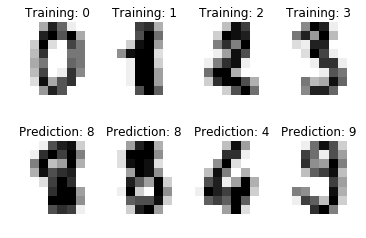

In [10]:
"""
================================
Recognizing hand-written digits
================================

An example showing how the scikit-learn can be used to recognize images of
hand-written digits.

This example is commented in the
:ref:`tutorial section of the user manual <introduction>`.

"""
print(__doc__)

# Author: Gael Varoquaux <gael dot varoquaux at normalesup dot org>
# License: BSD 3 clause

# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# We learn the digits on the first half of the digits
classifier.fit(data[:n_samples // 2], digits.target[:n_samples // 2])

# Now predict the value of the digit on the second half:
expected = digits.target[n_samples // 2:]
predicted = classifier.predict(data[n_samples // 2:])

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for index, (image, prediction) in enumerate(images_and_predictions[:4]):
    plt.subplot(2, 4, index + 5)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Prediction: %i' % prediction)

plt.show()
